# Cleaning and Filtering step

In [1]:
import pandas as pd
from transformers import AutoTokenizer
import re

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Load the original data

In [2]:
df = pd.read_parquet("./data/original-latam-xix.parquet")
current_len, original_len = len(df), len(df)
df

,newspaper_id,text_id,title,year,city,text
0,PD168,1-page_0-0,El oso,1845,"Lima, Perú",La publicacion del Oso se harà dos veces cada ...
1,PD168,1-page_0-1,El oso,1845,"Lima, Perú","-De ningun modo , gritó la Hiena terriblemente..."
2,PD168,1-page_0-2,El oso,1845,"Lima, Perú",Un real. 123
3,PD168,1-page_0-3,El oso,1845,"Lima, Perú",") Se Publica Miercoles y Sabado. LIMA , MIERCO..."
4,PD168,1-page_1-0,El oso,1845,"Lima, Perú","58 ba. Solo el Camaleon es partidario mio, y ¡..."
...,...,...,...,...,...,...
10502,PF746,28-page_0-0,PF746_El duende_Panama,1898-1903,Panamá,TARJETA La Dirección de EL DUENDE se une a la ...
10503,PF746,28-page_0-1,PF746_El duende_Panama,1898-1903,Panamá,"(A Marroco) de Loth. ena che es, mas fare que ..."
10504,PF746,28-page_0-2,PF746_El duende_Panama,1898-1903,Panamá,EL DUENDE Ecos de sociedad. 2835 mmm soldado l...
10505,PF746,28-page_0-3,PF746_El duende_Panama,1898-1903,Panamá,Dios hizo a la mujer de miel y rosa Para que d...


## 1. Remove duplicates and empty texts

In [3]:
to_remove = df[df.duplicated(subset=["text", "year"], keep=False)]
df = df.drop_duplicates(subset=["text", "year"], keep="first")
df = df.reset_index(drop=True)
print(f"Removed {current_len - len(df)} rows [{(current_len - len(df))/original_len:.2%}]")
current_len = len(df)
to_remove.tail(5)

Removed 108 rows [1.03%]


,newspaper_id,text_id,title,year,city,text
10279,PF730,20230917_113327-page_0-1,PF730_Mefistofeles,1897-1905,Bogotá,"architas su perfume, y la hoja seca rocío esti..."
10284,PF730,20230917_113546 (1)-page_0-0,PF730_Mefistofeles,1897-1905,Bogotá,Gallardía y patriotismo Así como en el ejercic...
10285,PF730,20230917_113546 (1)-page_0-1,PF730_Mefistofeles,1897-1905,Bogotá,compuesta de mujeres y hombres seltese acer Ll...
10286,PF730,20230917_113546-page_0-0,PF730_Mefistofeles,1897-1905,Bogotá,Gallardía y patriotismo Así como en el ejercic...
10287,PF730,20230917_113546-page_0-1,PF730_Mefistofeles,1897-1905,Bogotá,compuesta de mujeres y hombres seltese acer Ll...


In [4]:
to_remove = df[df['text'].astype(str).str.len() == 0]
df = df[df['text'].astype(str).str.len() > 0]
df = df.reset_index(drop=True)
print(f"Removed {current_len - len(df)} rows [{(current_len - len(df))/original_len:.2%}]")
current_len = len(df)
to_remove.tail(5)

Removed 3 rows [0.03%]


,newspaper_id,text_id,title,year,city,text
596,PD287,p17054coll26_486-page_1-2,El aficionado,1874,"Yarumal, Antioquia",
1977,PD662,ps19_elfisgon_1873_pte1-page_14-2,El fisgon,1873-1874,Bogotá,
6441,PD747,8-page_8-2,Colombia ilustrada,1889-1892,Bogotá,


## 2. Remove rows where 50%+ of the characters are not letters

In [5]:
def useful_chars(string):
    return re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', string)

In [6]:
idx_min = []
for i, sentence in enumerate(df['text'].astype(str)):
    sentence = re.sub(r'\s+', ' ', sentence.strip())
    size = len(sentence)
    letters_pctg = (size-len(useful_chars(sentence)))/size
    if letters_pctg > 0.5:
        idx_min.append(i)

print("\n".join([df.loc[i, "text"] for i in idx_min]))

.... 894 879 528 434 426 2 12003
85
101 00
133
61 2 3 ... 3
149
157
ohot 001861
.... .1 .. 0 .. .... 2 ... .6 ...... 00,001 . 117,604
141
9m 11 24718 , 1103
189 à
. 45,778 ..... 34,741 20 122 9 3/4 0 7 .. . 1,000 10,000 124
22.
-$ 10.000,000 14.000,000 Suma $. 24.000,000
$ 500,000
$ 200 80 --50 150 80 100 Suma ... L- $ 660
NÚMERO 177 .. $ 4,958 40 14,537 25 35,426 7 4,587 35 3,233 20 1.319 30 149,479 824 8,488 221 6 ... 15,917 65 ....... 12,542 55 9.778 55 11,698 20 9,046 57+ 4,398 S5 12.235 55 19,500 70 14,660 60 1.731 60 89.083 .$ 430,609 924
820 8 .80 10
....... $ 25. 25-20 25 75-20
NÚMERO 118. " Isabel de Borbón." 180,000.000 250,000.000 50,000,000 150,000.000 125,000.000 Total . 755,000.000
-
40 .. ....... 25 .. 148 6 8 44 15 . . 70 ... 60 80 ....... 50 7 .. ...... ..... 1 2 4 . .. 82 .. $ de á ocho décimos 550 4
$ 0 50 0 60 ) 80 0 05
$ ) 50 60 80 0 05
...
22 DE SETIEMBRE DE 1882. DIVIDENDO POR CADA TOTALES ACCIÓN $ 20 $ 22,675 25 18,140 16 14,512 20 18,140 15 25 13,605 22,675 20 

In [7]:
df.drop(idx_min, inplace=True)
df = df.reset_index(drop=True)
print(f"Removed {current_len - len(df)} rows [{(current_len - len(df))/original_len:.2%}]")
current_len = len(df)

Removed 90 rows [0.86%]


## 3. Remove the rows that have too few tokens

The paremeter chosen was `6` tokens, including the [CLS] and [SEP] tokens, so the rows to remove really have less than `4` tokens

### 3.1. Train a new tokenizer, based on the original dataset

This is particularly useful for then removing the rows with very few tokens, which are likely to be noise.

In [8]:
VOCAB_SIZE = 52000
TRAINING_BATCH_SIZE = 1000
HF_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-cased"

pretrained_tokenizer = AutoTokenizer.from_pretrained(HF_CHECKPOINT)

training_corpus = (
    df.loc[i:i+TRAINING_BATCH_SIZE, "text"].astype(str) 
    for i in range(0, len(df), TRAINING_BATCH_SIZE)
)

tokenizer = pretrained_tokenizer.train_new_from_iterator(training_corpus, VOCAB_SIZE)

In [9]:
example = df.loc[5, "text"]
print("BEFORE:", pretrained_tokenizer.tokenize(example)[:20])
print("AFTER:", tokenizer.tokenize(example)[:20])
#tokenizer.save_pretrained("./data/tokenizer")

BEFORE: ['Bur', '##ro', 'despues', 'de', 'un', 'corto', 'pero', 'fuerte', 'reco', '##ji', '##miento', 'de', 'espíritu', ',', 'como', 'para', 'recordar', 'ideas', 'conce', '##bidas']
AFTER: ['Burro', 'despues', 'de', 'un', 'corto', 'pero', 'fuerte', 'recoj', '##imiento', 'de', 'espíritu', ',', 'como', 'para', 'recordar', 'ideas', 'concebida', '##s', 'ya', 'hacia']


### 3.2. Actually find and remove the rows

In [10]:
MIN_TOKENS_LENGTH = 6 # 4 tokens: <[CLS] token1 token2 token3 token4 [SEP]>

idx_min = []
for i, sentence in enumerate(df['text'].astype(str)):
    num_tokens = len(tokenizer(sentence)['input_ids'])
    if num_tokens < MIN_TOKENS_LENGTH:
        print(f"Removed '{sentence}' [{i}, {num_tokens} tokens]")
        idx_min.append(i)

Removed 'cer' [25, 3 tokens]
Removed 'D. EL' [91, 5 tokens]
Removed 'C' [92, 3 tokens]
Removed 'Un real.' [105, 5 tokens]
Removed '127 oso' [166, 4 tokens]
Removed 'Los' [229, 3 tokens]
Removed 'Unreal.' [237, 5 tokens]
Removed 'VOLT.' [314, 5 tokens]
Removed 'Un real' [322, 4 tokens]
Removed 'que' [330, 3 tokens]
Removed 'que sa' [352, 4 tokens]
Removed 'Los cuadrupe' [368, 5 tokens]
Removed 'le' [371, 3 tokens]
Removed 'SENEC.' [384, 5 tokens]
Removed 'de' [393, 3 tokens]
Removed 'Un R.' [468, 5 tokens]


Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors


Removed 'Rousseau Continuara:' [555, 5 tokens]
Removed 'NUMERO 2.' [1596, 5 tokens]
Removed '2con5' [1610, 5 tokens]
Removed 'A animar C' [1673, 5 tokens]
Removed 'IV V' [1767, 4 tokens]
Removed 'VI VII' [1770, 4 tokens]
Removed 'VIII IX' [1771, 4 tokens]
Removed 'Rod' [1839, 3 tokens]
Removed 'Interac dejar' [1937, 5 tokens]
Removed 'VI VII' [2078, 4 tokens]
Removed 'III IV' [2090, 4 tokens]
Removed 'en de' [2100, 4 tokens]
Removed 'ban aumentado da' [2111, 5 tokens]
Removed 'Alberto Urdaneta.' [2141, 5 tokens]
Removed 'PRO PATRIA.' [2142, 5 tokens]
Removed 'Demetrio Porras.' [2324, 5 tokens]
Removed 'I' [2396, 3 tokens]
Removed 'Manuel le San' [2505, 5 tokens]
Removed 'II III' [2564, 4 tokens]
Removed 'IV V' [2568, 4 tokens]
Removed 'no ya' [2613, 4 tokens]
Removed 'Manuel Briceño.' [2708, 5 tokens]
Removed 'VII VIII IX' [3350, 5 tokens]
Removed 'III' [3379, 3 tokens]
Removed 'V VI VII' [3474, 5 tokens]
Removed 'X XIV' [3481, 4 tokens]
Removed 'V VI' [3566, 4 tokens]
Removed 'XI XII'

In [11]:
df.drop(idx_min, inplace=True)
df = df.reset_index(drop=True)
print(f"Removed {current_len - len(df)} rows [{(current_len - len(df))/original_len:.2%}]")
current_len = len(df)

Removed 88 rows [0.84%]


In [12]:
print(f"Final rows: {len(df)}")
df

Final rows: 10218


,newspaper_id,text_id,title,year,city,text
0,PD168,1-page_0-0,El oso,1845,"Lima, Perú",La publicacion del Oso se harà dos veces cada ...
1,PD168,1-page_0-1,El oso,1845,"Lima, Perú","-De ningun modo , gritó la Hiena terriblemente..."
2,PD168,1-page_0-2,El oso,1845,"Lima, Perú",Un real. 123
3,PD168,1-page_0-3,El oso,1845,"Lima, Perú",") Se Publica Miercoles y Sabado. LIMA , MIERCO..."
4,PD168,1-page_1-0,El oso,1845,"Lima, Perú","58 ba. Solo el Camaleon es partidario mio, y ¡..."
...,...,...,...,...,...,...
10213,PF746,28-page_0-0,PF746_El duende_Panama,1898-1903,Panamá,TARJETA La Dirección de EL DUENDE se une a la ...
10214,PF746,28-page_0-1,PF746_El duende_Panama,1898-1903,Panamá,"(A Marroco) de Loth. ena che es, mas fare que ..."
10215,PF746,28-page_0-2,PF746_El duende_Panama,1898-1903,Panamá,EL DUENDE Ecos de sociedad. 2835 mmm soldado l...
10216,PF746,28-page_0-3,PF746_El duende_Panama,1898-1903,Panamá,Dios hizo a la mujer de miel y rosa Para que d...


In [13]:
df.to_csv("./data/cleaned-latam-xix.tsv", sep="\t", index=False)
df.to_parquet('./data/cleaned-latam-xix.parquet')

## Post-analysis

In [26]:
originaldf = pd.read_parquet("./data/original-latam-xix.parquet")
# select all rows that are on originaldf but not in df
removed_df = originaldf.merge(df, how='left', indicator=True).loc[lambda x: x['_merge'] == 'left_only']

removed_df['year'] = removed_df['year'].str.split('-').str[0]
removed_df['year'] = removed_df['year'].astype(int)

removed_df

,newspaper_id,text_id,title,year,city,text,_merge
25,PD168,2-page_10-2,El oso,1845,"Lima, Perú",cer,left_only
52,PD168,2-page_23-2,El oso,1845,"Lima, Perú",.... 894 879 528 434 426 2 12003,left_only
53,PD168,2-page_23-3,El oso,1845,"Lima, Perú",85,left_only
93,PD168,2-page_4-1,El oso,1845,"Lima, Perú",D. EL,left_only
94,PD168,2-page_4-2,El oso,1845,"Lima, Perú",C,left_only
...,...,...,...,...,...,...,...
10259,PF730,20230917_113222-page_0-1,PF730_Mefistofeles,1897,Bogotá,Materialmente como lo hiciera un Júpiter á un ...,left_only
10278,PF730,20230917_113327-page_0-0,PF730_Mefistofeles,1897,Bogotá,Adelante ! MEFISTOFELES día es mayor el entusi...,left_only
10279,PF730,20230917_113327-page_0-1,PF730_Mefistofeles,1897,Bogotá,"architas su perfume, y la hoja seca rocío esti...",left_only
10286,PF730,20230917_113546-page_0-0,PF730_Mefistofeles,1897,Bogotá,Gallardía y patriotismo Así como en el ejercic...,left_only


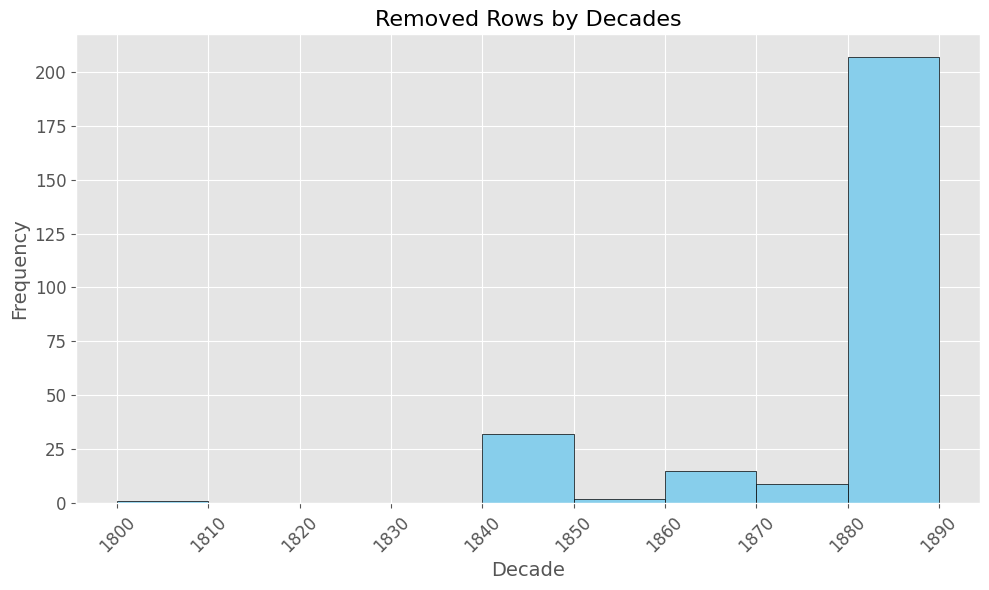

All Decades:
[1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890]


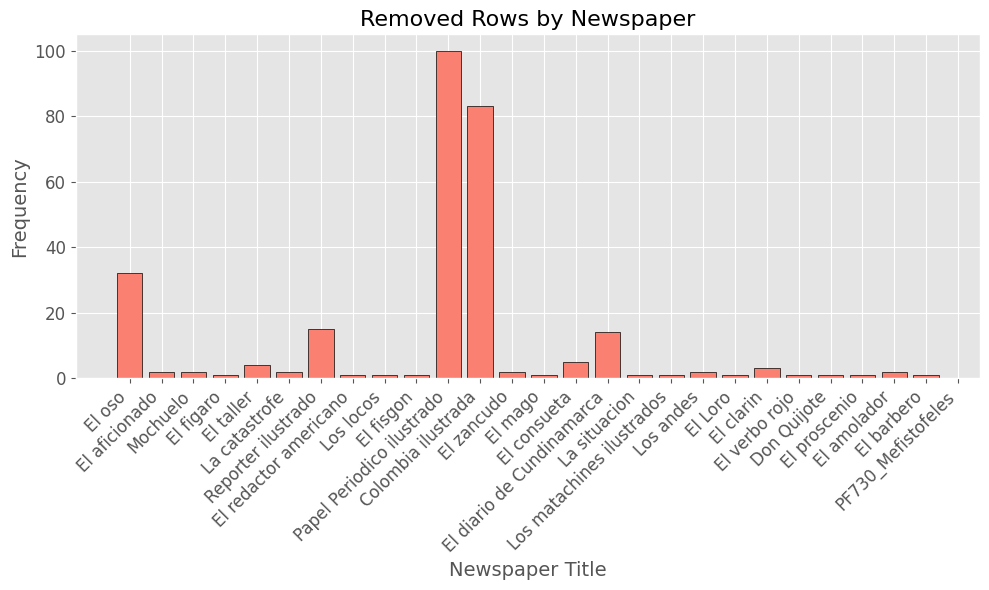

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Set style
plt.style.use('ggplot')

min_year = removed_df['year'].min()
max_year = removed_df['year'].max()
decades_range = np.arange((min_year // 10) * 10, ((max_year // 10) + 1) * 10, 10)

# Create a histogram by decades for the 'year' column
plt.figure(figsize=(10, 6))
plt.hist(removed_df['year'], bins=decades_range, color='skyblue', edgecolor='black')
plt.title('Removed Rows by Decades', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(decades_range, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('./imgs/removed_years_histogram.png', dpi=300)  # Save the plot as an image
plt.show()

# Print all decades even if there are no rows in the dataframe for those decades
print("All Decades:")
print(list(decades_range))

# Plot individual bars for each title in the 'title' column
plt.figure(figsize=(10, 6))
plt.hist(removed_df['title'], color='salmon', edgecolor='black', bins=np.arange(len(removed_df['title'].unique())) - 0.5, rwidth=0.8)
plt.title('Removed Rows by Newspaper', fontsize=16)
plt.xlabel('Newspaper Title', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('./imgs/removed_titles_histogram.png', dpi=300)  # Save the plot as an image
plt.show()
